In [1]:
import h5py
import numpy as np
import matplotlib as mpl
from matplotlib import pyplot as plt
import os
from pathlib import Path
import pyfftw

import bacco

import sys
sys.path.append('/dipc/kstoreyf/muchisimocks/scripts')
import plotter
import plot_utils
import utils
import compute_statistics as cs
import data_loader
import generate_params as genp

%load_ext autoreload
%autoreload 2

2026-01-08 11:07:22.041301: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-01-08 11:07:22.145394: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2026-01-08 11:07:22.145433: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2026-01-08 11:07:22.158806: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-01-08 11:07:22.190344: I tensorflow/core/platform/cpu_feature_guar

# Inference: kmax=0.2 for bispec (20x bias per cosmo)

## load training: Anmult p2

In [2]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p2_n200000'

n_train = 10000
#statistics_arr = [['pk']]
#statistics_arr = [['pk'], ['bispec']]
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tag_mask_arr = ['', '_kmaxbispec0.2', '_kmaxbispec0.2']

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats_arr[i]}{tag_mask_arr[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for i in range(len(tag_stats_arr))
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [3]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [4]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
11
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.    ]
11


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_muchisimocks_bispec_kmaxbispec0.2_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_kmaxbispec0.2_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


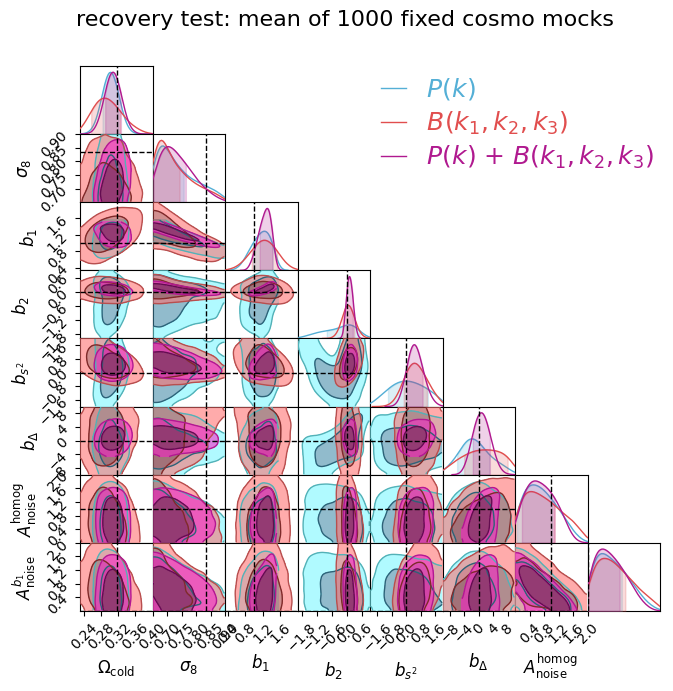

In [5]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### Inference results: shame

In [6]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_shame_bispec_kmaxbispec0.2_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_shame_pk_bispec_kmaxbispec0.2_nbar0.00022_pred.npy


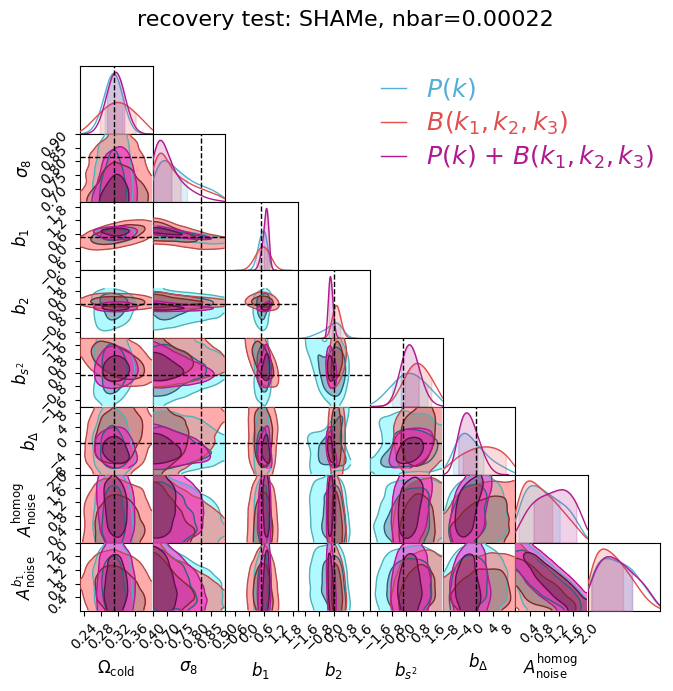

In [7]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mask_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

## load training: Anmult p5

In [8]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'

n_train = 10000
#statistics_arr = [['pk']]
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tag_mask_arr = ['', '_kmaxbispec0.2', '_kmaxbispec0.2']

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats_arr[i]}{tag_mask_arr[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for i in range(len(tag_stats_arr))
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [9]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [10]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
14
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.     0.     0.     0.    ]
14


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_kmaxbispec0.2_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_kmaxbispec0.2_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


Parameter b2 in chain $P(k)$ is not constrained


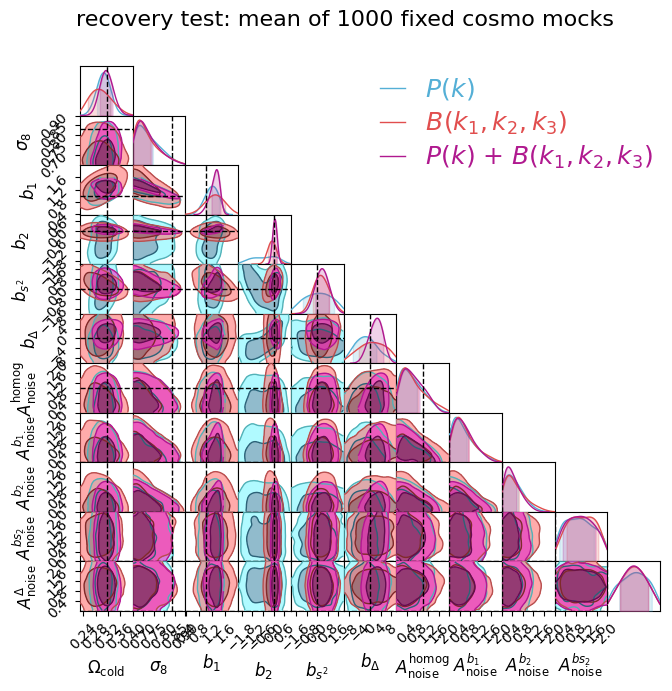

In [11]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### Inference results: shame

In [12]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan         nan
         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_bispec_kmaxbispec0.2_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.2_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_bispec_kmaxbispec0.2_nbar0.00022_pred.npy


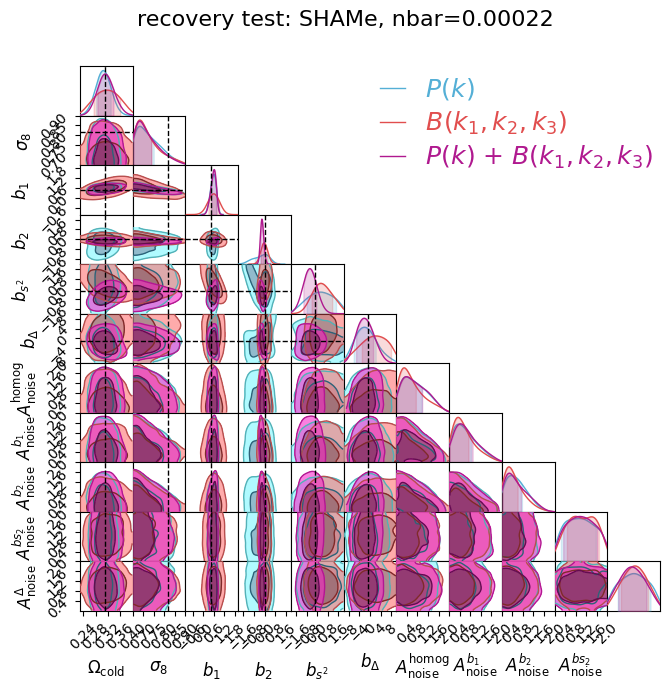

In [13]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mask_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

# Inference: kmax=0.3 for bispec

## load training: Anmult p2

In [17]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p2_n200000'

n_train = 10000
#statistics_arr = [['pk']]
#statistics_arr = [['pk'], ['bispec']]
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tag_mask_arr = ['', '_kmaxbispec0.3', '_kmaxbispec0.3']

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats_arr[i]}{tag_mask_arr[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for i in range(len(tag_stats_arr))
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [18]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [19]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
11
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.    ]
11


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_muchisimocks_bispec_kmaxbispec0.3_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_kmaxbispec0.3_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


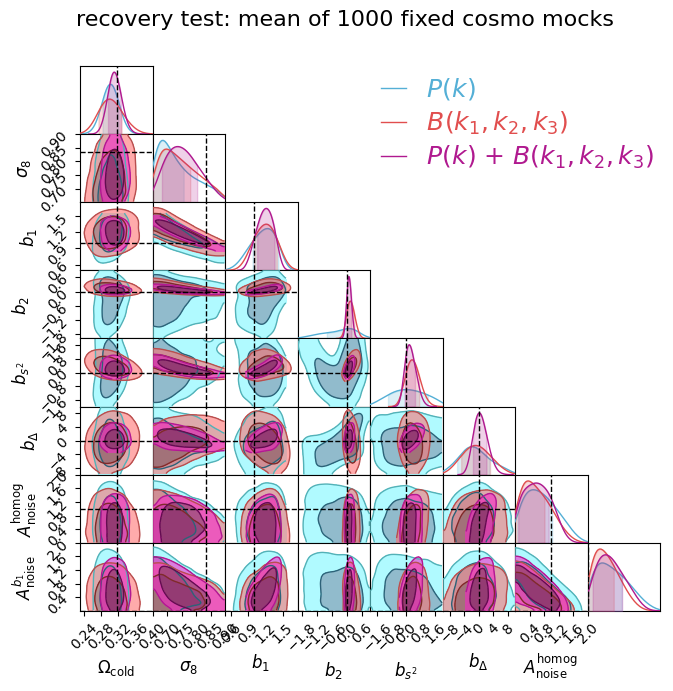

In [20]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### Inference results: shame

In [21]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_shame_bispec_kmaxbispec0.3_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p2_n200000_ntrain10000/samples_test_shame_pk_bispec_kmaxbispec0.3_nbar0.00022_pred.npy


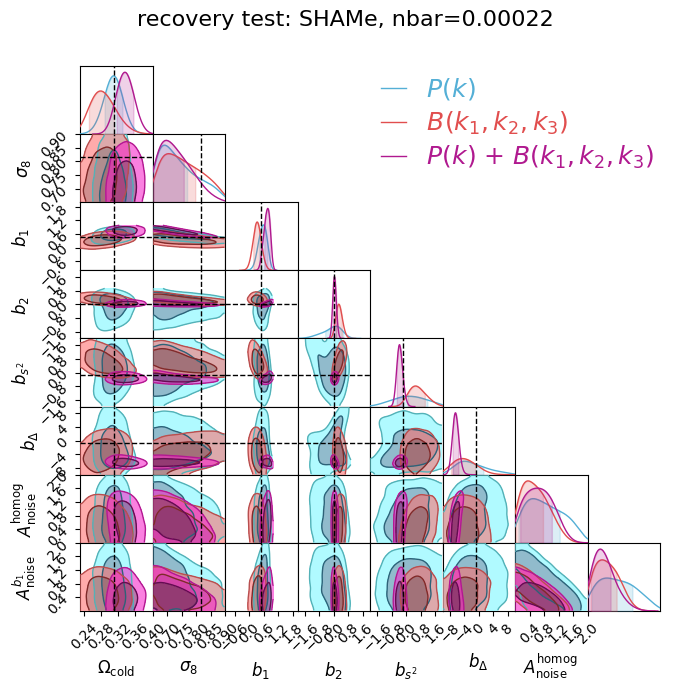

In [22]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mask_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

## load training: Anmult p5

In [23]:
data_mode = 'muchisimocks'
tag_params = '_p5_n10000'
tag_biasparams = '_biaszen_p4_n200000'
tag_noise = '_noise_unit_p5_n10000'
tag_Anoise = '_Anmult_p5_n200000'

n_train = 10000
#statistics_arr = [['pk']]
statistics_arr = [['pk'], ['bispec'], ['pk', 'bispec']]
tag_stats_arr = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tag_mask_arr = ['', '_kmaxbispec0.3', '_kmaxbispec0.3']

# muchisimocks_pk_p5_n10000_biaszen_p4_n10000_ntrain10000
tags_inf = [
             f'_{data_mode}{tag_stats_arr[i]}{tag_mask_arr[i]}{tag_params}{tag_biasparams}{tag_noise}{tag_Anoise}_ntrain{n_train}' for i in range(len(tag_stats_arr))
            ]
inf_methods = ['sbi']*len(tags_inf)
labels = [utils.get_stat_label(stat) for stat in statistics_arr]
color_pk = '#54afd6'
color_bispec = "#e14e4e"
color_pkbispec = '#b0198f'
colors = [color_pk, color_bispec, color_pkbispec]

In [24]:
# load training set parameters 
params_df, param_dict_fixed, biasparams_df, biasparams_dict_fixed, Anoise_df, Anoise_dict_fixed, random_ints, random_ints_bias = data_loader.load_params(tag_params, tag_biasparams, tag_Anoise=tag_Anoise)

# for muchisimocks, we will probably want to vary the same params as the training data
cosmo_param_names_vary, bias_param_names_vary, noise_param_names_vary = [], [], []
if params_df is not None:
    cosmo_param_names_vary = params_df.columns.tolist()
# TODO should this be test or train?
if biasparams_df is not None:
    bias_param_names_vary = biasparams_df.columns.tolist()
if Anoise_df is not None:
    noise_param_names_vary = Anoise_df.columns.tolist()
param_names_vary = cosmo_param_names_vary + bias_param_names_vary + noise_param_names_vary
param_labels = [utils.param_label_dict[param_name] for param_name in param_names_vary]
print(param_names_vary)

['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']


### Inference results: cosmic variance / fixed cosmo (quijote)

In [25]:
# load fixed-cosmo test set
tag_params_test_fixed = '_quijote_p0_n1000'
tag_biasparams_test_fixed = '_b1000_p0_n1'
tag_noise_fixed = '_noise_unit_quijote_p0_n1000'
tag_Anoise_fixed = '_Anmult_p0_n1'
theta_test_fixed = data_loader.load_theta_test(tag_params_test_fixed, tag_biasparams_test_fixed, 
                                               tag_Anoise_test=tag_Anoise_fixed,
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary,
                                noise_param_names_vary=noise_param_names_vary)
print(theta_test_fixed)
print(len(theta_test_fixed))

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params_test_fixed)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams_test_fixed)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise_fixed)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

tag_Anoise_test _Anmult_p0_n1
['An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
{'An_homog': 1.0, 'An_b1': 0.0, 'An_b2': 0.0, 'An_bs2': 0.0, 'An_bl': 0.0}
here
14
[0.3175 0.834  0.6711 0.049  0.9624 1.     0.     0.     0.     1.
 0.     0.     0.     0.    ]
14


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_bispec_kmaxbispec0.3_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_muchisimocks_pk_bispec_kmaxbispec0.3_quijote_p0_n1000_b1000_p0_n1_noise_unit_quijote_p0_n1000_Anmult_p0_n1_mean_pred.npy


Parameter b2 in chain $P(k)$ is not constrained


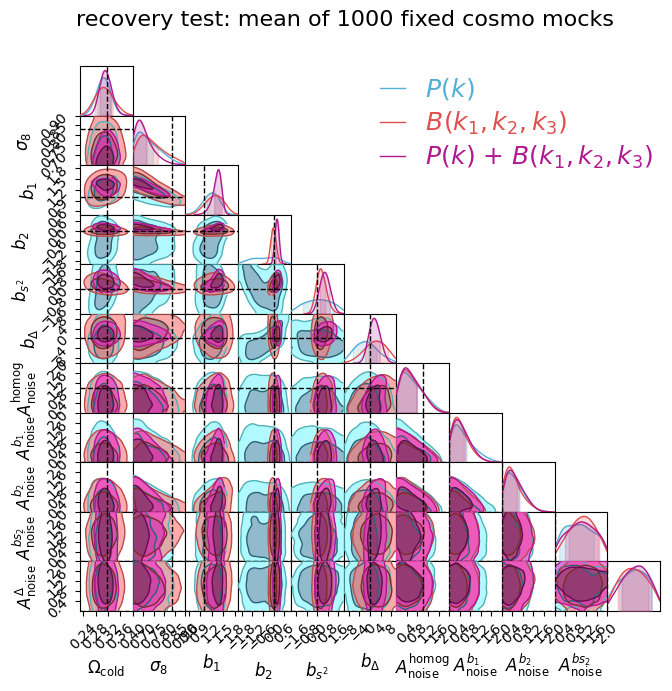

In [26]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: mean of 1000 fixed cosmo mocks'
tags_stats = [f'_{"_".join(statistics)}' for statistics in statistics_arr]
tags_test = ['_'+data_mode + tag_stats_arr[i] + tag_mask_arr[i] + tag_params_test_fixed + tag_biasparams_test_fixed + tag_noise_fixed + tag_Anoise_fixed + '_mean' for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test_fixed[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

### Inference results: shame

In [27]:
# load fixed-cosmo test set
data_mode_test = 'shame'
tag_mock = '_nbar0.00022'
theta_test = data_loader.load_theta_ood(data_mode_test, tag_mock, 
                                cosmo_param_names_vary=cosmo_param_names_vary, bias_param_names_vary=bias_param_names_vary, noise_param_names_vary=noise_param_names_vary)
print(theta_test)

# get bounds
_, dict_bounds_cosmo, _ = genp.define_LH_cosmo(tag_params)
_, dict_bounds_bias, _ = genp.define_LH_bias(tag_biasparams)
_, dict_bounds_Anoise, _ = genp.define_LH_Anoise(tag_Anoise)
extents = {**dict_bounds_cosmo, **dict_bounds_bias, **dict_bounds_Anoise}

[ 0.3089      0.81590003  0.6774      0.0486      0.9667      0.47410742
  0.03175373 -0.16940883 -0.82443643         nan         nan         nan
         nan         nan]


['omega_cold', 'sigma8_cold', 'hubble', 'omega_baryon', 'ns', 'b1', 'b2', 'bs2', 'bl', 'An_homog', 'An_b1', 'An_b2', 'An_bs2', 'An_bl']
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_bispec_kmaxbispec0.3_nbar0.00022_pred.npy
fn_samples = ../results/results_sbi/sbi_muchisimocks_pk_bispec_kmaxbispec0.3_p5_n10000_biaszen_p4_n200000_noise_unit_p5_n10000_Anmult_p5_n200000_ntrain10000/samples_test_shame_pk_bispec_kmaxbispec0.3_nbar0.00022_pred.npy


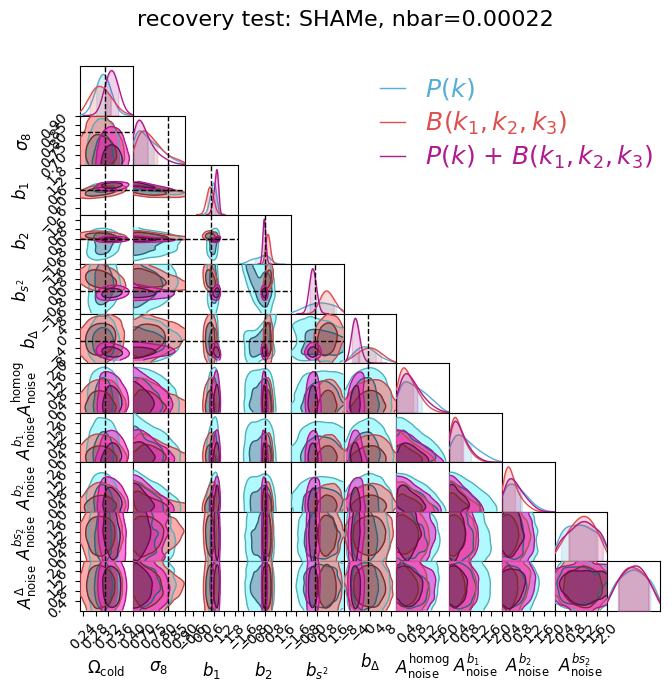

In [28]:
print(param_names_vary)
idx_obs = 0
title = f'recovery test: SHAMe, nbar={tag_mock.split("nbar")[-1]}'
tags_test = ['_'+data_mode_test + tag_stats_arr[i] + tag_mask_arr[i] + tag_mock for i in range(len(tag_stats_arr))]

#tags_test = [f'{tag_data_test_fixed}_mean']*len(tags_inf)
# doing utils.biasparam_names_ordered here instead of bias_param_names_vary in case some param sets don't vary all the bias params but we want to show them on the same plot
#param_names_contour = cosmo_param_names_vary + noise_param_names_vary
param_names_contour = ['omega_cold', 'sigma8_cold'] + utils.biasparam_names_ordered + noise_param_names_vary
theta_test_show = theta_test[[i for i, name in enumerate(param_names_vary) if name in param_names_contour]]

plotter.plot_contours_inf(param_names_contour, idx_obs, theta_test_show, 
                        inf_methods, tags_inf, tags_test=tags_test,
                        colors=colors, labels=labels,
                        title=title, extents=extents)

# checking k values

In [14]:
k_min = 0.01
k_max = 0.4
n_bins = 7
k_edges = np.linspace(k_min, k_max, n_bins+1) # 7 bins
print(k_edges)

[0.01       0.06571429 0.12142857 0.17714286 0.23285714 0.28857143
 0.34428571 0.4       ]


In [15]:
statistics = ['bispec']
k_mock_full, y_mock_full, y_err_mock_full = data_loader.load_data_ood(
    data_mode_test, statistics, tag_mock, tag_data=None
)

Loaded bispec with shape (50,)
Loaded bispec data with shape (50,)
No tag_data provided, so not masking data


In [16]:
np.unique(k_mock_full)

array([0.03785714, 0.09357143, 0.14928571, 0.205     , 0.26071429,
       0.31642857, 0.37214286])